In [1]:
import pandas as pd
from src.category_tree.category_tree import CategoryTree

CAT_PATH = "../data/category_tree.csv"
TRAIN_LABELED_PATH = "../data/labeled_train.parquet"

CAT_ID_COL = "cat_id"
TITLE_COL = "source_name"

In [2]:
df = pd.read_parquet(TRAIN_LABELED_PATH, columns=[TITLE_COL, CAT_ID_COL])
category_tree = CategoryTree(category_tree_path=CAT_PATH)

# Средняя степень предка листа

Для каждого предка листа посчитаем степень вершины(количество листев-соседей)

Видно, что в среднем листев не очень много(порядка 1-4)

In [3]:
import networkx as nx
import numpy as np
import seaborn as sns

In [4]:
cat_tree = category_tree._category_tree_graph

leaf_parent_nodes = []
for node in cat_tree.nodes:
    if node not in category_tree.leaf_nodes:
        if (set(nx.neighbors(cat_tree, node)) & set(category_tree.leaf_nodes)) == set(nx.neighbors(cat_tree, node)):
            leaf_parent_nodes.append(node)


In [5]:
len(category_tree.leaf_nodes), len(cat_tree.nodes)

(1406, 1897)

In [6]:
len(leaf_parent_nodes)

337

In [7]:
degrees = [cat_tree.out_degree(node) for node in leaf_parent_nodes]
np.mean(degrees), np.min(degrees), np.max(degrees), np.quantile(degrees, 0.95)

(2.878338278931751, 1, 13, 7.0)

<Axes: ylabel='Count'>

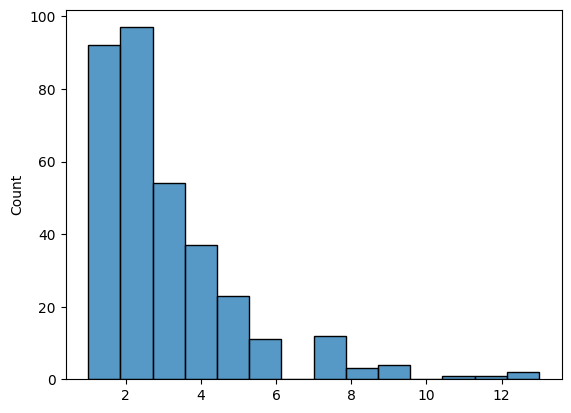

In [8]:
sns.histplot(degrees)

# Средняя степень предка листа(если у предка есть соседи нелистья)

У части вершин есть соседи разных типов (листь и "нелистья") -- посмотрим сколько листьев из них достижимо

Видно, что в таких кейсах можно получаем давольно много листьев соседей

In [9]:
def count_reachable_leafs(graph):
    leaf_nodes = [node for node in graph.nodes if graph.out_degree(node) == 0]
    leaf_count = {}
    
    def dfs(node):
        if node in leaf_count:
            return leaf_count[node]
      
        if graph.out_degree(node) == 0:
            leaf_count[node] = 1
            return 1
        
        total_leafs = 0
        for child in graph.successors(node):
            total_leafs += dfs(child)
        
        leaf_count[node] = total_leafs
        return total_leafs
    
    for node in graph.nodes:
        if node not in leaf_count:
            dfs(node)
    
    return leaf_count

In [10]:
leaf_parent_nodes_mixed = []
for node in cat_tree.nodes:
    if node not in category_tree.leaf_nodes:
        if len(set(nx.neighbors(cat_tree, node)) & set(category_tree.leaf_nodes)) != 0:
            if (set(nx.neighbors(cat_tree, node)) & set(category_tree.leaf_nodes)) < set(nx.neighbors(cat_tree, node)):
                leaf_parent_nodes_mixed.append(node)

In [11]:
reachable_leafs_cnts = count_reachable_leafs(cat_tree)

In [12]:
assert reachable_leafs_cnts[category_tree.leaf_nodes[0]] == 1

In [13]:
assert reachable_leafs_cnts[0] == len(category_tree.leaf_nodes)

16.387096774193548 2 186 47.69999999999999


<Axes: ylabel='Count'>

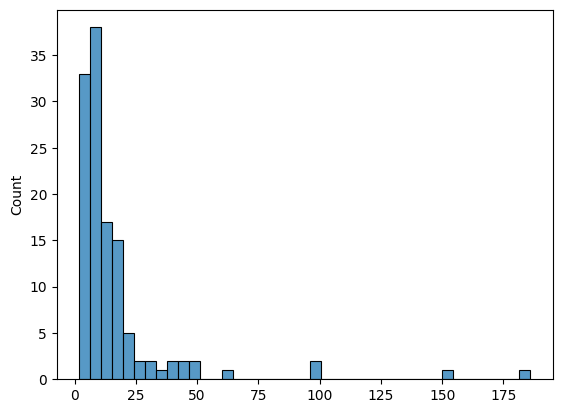

In [14]:
parent_degrees_mixed = [reachable_leafs_cnts[node] for node in leaf_parent_nodes_mixed]
print(np.mean(parent_degrees_mixed), np.min(parent_degrees_mixed), np.max(parent_degrees_mixed), np.quantile(parent_degrees_mixed, 0.95))
sns.histplot(parent_degrees_mixed)

# Количество листов у нелистовых вершин
В выборке есть 100k примеров с нелистовой разметкой:
- 61 уникальных вершин
- 44 -- вершины с соседями-листями
- 13 -- вершины со смешанными соседями
- По большей части степени не такие большие(90 квантиль = 13)
- (80k) Для вершины с соседями-листями статистики зорошие (2-5 соседа) -- можно просто размазать лэйбл
- (20k) Для вершины со смешанными соседями опасно размазывать лэйблы

In [15]:
df_non_leaf = df[~df[CAT_ID_COL].isin(category_tree.leaf_nodes)]

In [16]:
df_non_leaf.shape

(101651, 2)

In [17]:
non_leaf_cats = df_non_leaf[CAT_ID_COL].unique().tolist()
len(non_leaf_cats)

61

In [18]:
len(set(non_leaf_cats) & set(leaf_parent_nodes)), len(set(non_leaf_cats) & set(leaf_parent_nodes_mixed)) 

(44, 13)

<Axes: ylabel='Count'>

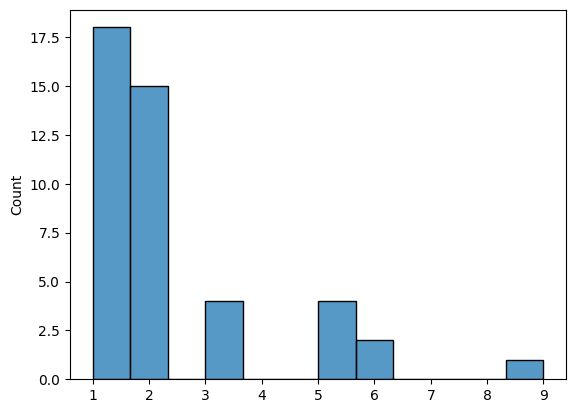

In [19]:
pure_non_leaf_cats = set(non_leaf_cats) & set(leaf_parent_nodes)
degrees_pure = [reachable_leafs_cnts[node] for node in pure_non_leaf_cats]
sns.histplot(degrees_pure)

In [20]:
np.quantile(degrees_pure, q=[0.5, 0.9, 0.95, 0.99])

array([2.  , 5.  , 5.85, 7.71])

<Axes: ylabel='Count'>

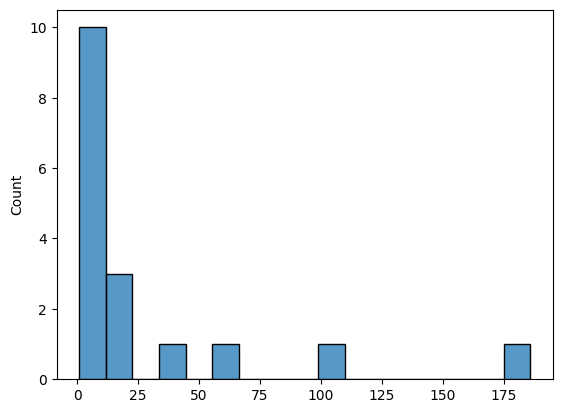

In [21]:
mixed_non_leaf_cats = set(non_leaf_cats) - set(leaf_parent_nodes)
degrees_mixed = [reachable_leafs_cnts[node] for node in mixed_non_leaf_cats]
sns.histplot(degrees_mixed)

In [22]:
np.quantile(degrees_mixed, q=[0.5, 0.9, 0.95, 0.99])

array([ 11.  ,  78.6 , 116.4 , 172.08])

# Категории нелистовых вершин
- Есть разные кейсы почему мы не в листе -- не везде можно просто размазать вероятность
- Иногда очевидно какая должна быть листовая вершина -- тут можно пробовать доразметку

In [23]:
cat_tree_df = pd.read_csv(CAT_PATH)

In [24]:
df_pure_non_leaf = df_non_leaf[df_non_leaf[CAT_ID_COL].isin(pure_non_leaf_cats)]

In [25]:
df_pure_non_leaf.head(10)

,source_name,cat_id
8,Ремешок для часов 18 мм универсальный металлич...,1006
11,"Телевизор Polar P43L32T2CSM, 43""""(109 см), FHD",1052
18,Ноутбук Lenovo IdeaPad 3 15IIL05 Gray (81WE01B...,1242
24,Глянцевая защитная premium-плёнка для смарт-ча...,1006
58,Ремешок для смарт-часов Grand Price 680601204 ...,1006
62,Ноутбук GIGABYTE Aorus 7 Black (BKF-73KZ654SD),1242
83,"Фотофон виниловый, 70х90 см, для предметной съ...",1142
96,"Защитный чехол для Redmi Watch 3 Lite, Watch 3...",1006
98,Ноутбук ASUS TUF Gaming FX506QM-HN050 Gray (90...,1242
116,Комплект фильтров TOP HOUSE TH 002SM для пылес...,1389


## Очевидный правильный лэйбл

In [26]:
df_pure_non_leaf.loc[58]

source_name    Ремешок для смарт-часов Grand Price 680601204 ...
cat_id                                                      1006
Name: 58, dtype: object

In [27]:
cat_tree_df[cat_tree_df["cat_id"]==1006]

,cat_id,parent_id,cat_name
229,1006,101.0,Аксессуары для смарт-часов


In [28]:
cat_tree_df[cat_tree_df["parent_id"]==1006]

,cat_id,parent_id,cat_name
970,10013,1006.0,Ремешки для умных часов
971,10014,1006.0,Аксессуары для умных часов и браслетов


## Ни один из лэйблов не подходит

In [29]:
df_pure_non_leaf.loc[11]

source_name    Телевизор Polar P43L32T2CSM, 43""(109 см), FHD
cat_id                                                   1052
Name: 11, dtype: object

In [30]:
cat_tree_df[cat_tree_df["cat_id"]==1052]

,cat_id,parent_id,cat_name
250,1052,104.0,Телевизоры


In [31]:
cat_tree_df[cat_tree_df["parent_id"]==1052]

,cat_id,parent_id,cat_name
1005,10122,1052.0,Телевизоры Xiaomi
1006,10127,1052.0,Телевизоры 65 дюймов


# Смешанный вариант

In [32]:
df_mixed_non_leaf = df_non_leaf[df_non_leaf[CAT_ID_COL].isin(mixed_non_leaf_cats)]

In [33]:
df_mixed_non_leaf.head(10)

,source_name,cat_id
1,Приемное устройство М1 TDM Уютный дом в монтаж...,140
28,Датчик температуры и влажности Яндекс с Zigbee...,140
34,"Беспроводной контроллер 220 Вольт, 433 МГц (уч...",140
115,Беспроводной выключатель GRITT Evolution 3кл. ...,140
120,Антенна Baltic Signal ASTRA 3G/4G MIMO (Панель...,126
123,Ключ для домофона RW1990 100шт перезаписываемы...,2633
147,Усилитель интернет сигнала Антекс 3G 4G LTE 15dBi,126
151,IP-телефон Fanvil A32i Black (A32I),126
172,Wi-Fi адаптер Selenga беспроводной без антенны...,126
182,"Наклейка на ноутбук виниловая 42х32 см, защитн...",1243


## Тупо не доделали разметку, есть очевидные варианты

In [34]:
df_mixed_non_leaf.loc[28]

source_name    Датчик температуры и влажности Яндекс с Zigbee...
cat_id                                                       140
Name: 28, dtype: object

In [35]:
cat_tree_df[cat_tree_df["cat_id"]==140]

,cat_id,parent_id,cat_name
61,140,3.0,Умный дом


In [36]:
cat_tree_df[cat_tree_df["parent_id"]==140]

,cat_id,parent_id,cat_name
417,1433,140.0,Бытовая техника
418,1434,140.0,Климат
419,1438,140.0,Безопасность
960,3683,140.0,Прочая техника для умного дома
